# Bacterial growth: theory and image analysis

This exercise was generated from a Jupyter notebook. You can download the notebook [here](bacterial_growth.ipynb).
___

In this tutorial we summarize the image analysis pipeline used in class to obtain an estimate of the bacterial growth rate using phase contrast mictroscopy images. We also present the analysis done on fluorescence microscopy images, which are segmented significantly better and yield more accurate estimates of the growth rate.

# Bacterial growth theory

If the environment has a sufficient amount of nutrients, bacteria will keep multiplying. Let's assume that the growth rate of bacteria is $\lambda$. If $N(t)$ is the number of bacteria at time $t$, after a time increment $\Delta t$, the number of bacteria will be

\begin{align}
N(t+\Delta t) = N(t) + \lambda \, N(t) \Delta t.
\end{align}

Taking the $\Delta t \rightarrow 0$ limit, we obtain the time evolution equation for N(t)

\begin{align}
\frac{N(t+\Delta t) - N(t)}{\Delta t} \approx \frac{\mathrm{d} N(t)}{\mathrm{d} t} = \lambda N(t).
\end{align}

Knowing the initial number of bacteria, $N_0$, the solution to the above ODE will be

\begin{align}
N(t) = N_0 e^{\lambda t}.
\end{align}

The doubling time of bacteria, $\tau$, is also of interest. It's defined as the time it takes for a bacterium to multiply, i.e.

\begin{align}
N(t+\tau) = 2 \times N(t).
\end{align}

Substituting the solution for $N(t)$, we find

\begin{align}
N_0 e^{\lambda(t+\tau)} &= 2N_0 e^{\lambda t} \Rightarrow \\
e^{\lambda \tau} &= 2 \Rightarrow \\
\tau &= \frac{\log 2}{\lambda}.
\end{align}

In what follows, we will analyze microscopy images of bacterial growth to estimate the growth rate $\lambda$ and the doubling time $\tau$.

## Analysis of phase contrast images

Now, let's use the high magnification microscopy images of a growing bacterial colony to estimate the rate of bacterial growth. In the `data/` folder you can see microscopy images taken in *phase contrast* and *fluorescence* methods in 5 minute intervals. The phase images are named `ecoli_phase_xx.tif`, and the flurescence ones are named `ecoli_TRITC_xx.tif`. Let's begin by taking a look at the phase images. 

In [36]:
# Import the necessary modules
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# For pretty plots
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14, \
    'xtick.labelsize' : 14, 'ytick.labelsize' : 14}
sns.set(rc=rc)

# For bulk acquisition of filenames
import glob

# For importing bacterial images
import skimage.io

In [37]:
# Read an example phase image
im = skimage.io.imread('../data/ecoli_growth/ecoli_phase_05.tif')

# Take a look at its contents
im

array([[370, 366, 350, ..., 355, 360, 352],
       [354, 363, 362, ..., 354, 357, 353],
       [359, 374, 365, ..., 356, 355, 356],
       ..., 
       [357, 359, 352, ..., 352, 352, 355],
       [349, 353, 362, ..., 342, 353, 353],
       [358, 360, 366, ..., 356, 350, 365]], dtype=uint16)

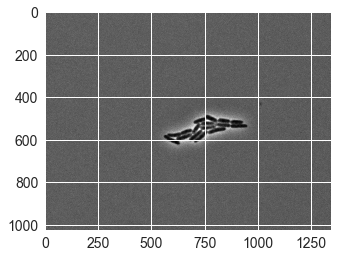

In [38]:
# Show the image in greyscale colormap
plt.imshow(im, cmap = plt.cm.Greys_r)

As you can see, the image is stored as a 2d-array of integers. Since a single channel is present, we'll show the image in greyscale.

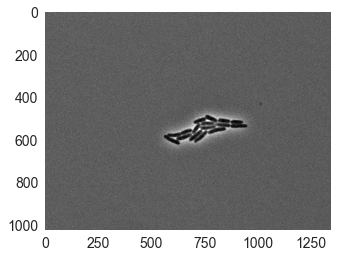

In [39]:
# Show the image in greyscale
plt.imshow(im, cmap=plt.cm.Greys_r)

# Turn off the grid
plt.grid('off')

Characteristic to phase contrast images, the bacterial colony is surrounded by a white "halo" that separates it from the background. It's not hard to identify the area that the colony occupies by eye. But can we make the computer do the same? In order to compare the contents of different images, let's renormalize the numerical values of pixels to be from `0` to `1`, where `0` would correspond to the darkest pixel and `1` to the lightest.

In [40]:
# Renormalize the pixel values to the [0, 1] range
im_float = (im - np.min(im)) / (np.max(im) - np.min(im))

# Show the contents again
im_float

array([[ 0.32444444,  0.31555556,  0.28      , ...,  0.29111111,
         0.30222222,  0.28444444],
       [ 0.28888889,  0.30888889,  0.30666667, ...,  0.28888889,
         0.29555556,  0.28666667],
       [ 0.3       ,  0.33333333,  0.31333333, ...,  0.29333333,
         0.29111111,  0.29333333],
       ..., 
       [ 0.29555556,  0.3       ,  0.28444444, ...,  0.28444444,
         0.28444444,  0.29111111],
       [ 0.27777778,  0.28666667,  0.30666667, ...,  0.26222222,
         0.28666667,  0.28666667],
       [ 0.29777778,  0.30222222,  0.31555556, ...,  0.29333333,
         0.28      ,  0.31333333]])

Let's hover over the pixels and get a sense of what values the background and bacterial pixels have.

<IPython.core.display.Javascript object>


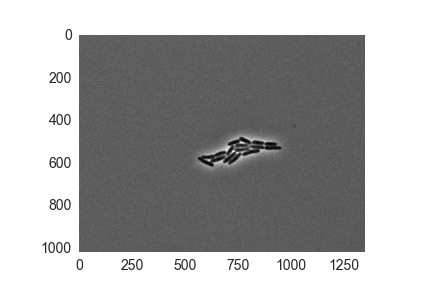

In [41]:
%matplotlib notebook

plt.imshow(im_float, cmap=plt.cm.Greys_r)
plt.grid('off')

It seems like the background pixels have values close to `0.25-0.30`, while the bacterial pixels have lower values `~0.1`. Let's make a histogram of all the pixel intensity values and see what the distribution looks like.

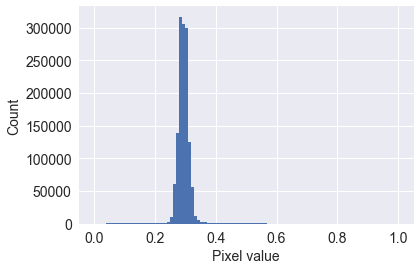

In [42]:
%matplotlib inline

# Conver the image into a 1d array
im_float_1d = im_float.flatten()

# Plot a histogram of pixel values
# note: '_' is used to suppress the output regarding bin information
_ = plt.hist(im_float.flatten(), bins=100)
plt.xlabel('Pixel value')
plt.ylabel('Count')
plt.show()

The peak that dominates the distribution is in the range where the background pixels were predicted to belong. We can try to segment the bacterial pixels by **thresholding** the image, i.e. any pixel value that is less than the threshold will be assigned a value of `1`, while the rest will be assigned a value of `0`. A threshold value of `0.2` looks appropriate for our case.

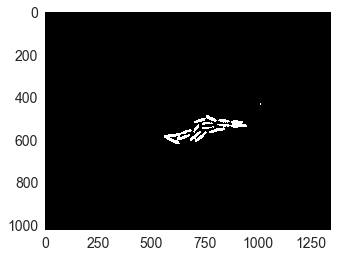

In [43]:
# Threshold value
threshold = 0.2

# Apply the threshold and show the segmented image
plt.imshow(im_float < threshold, cmap = plt.cm.Greys_r)
plt.grid('off')

Looks like thresholding did a decent job in isolating the bacterial cells! Let's follow the same procedure for an image at a later frame.

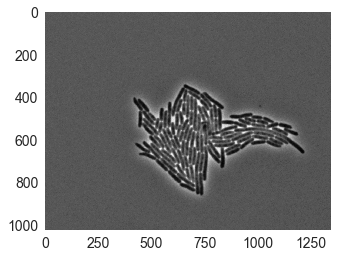

In [44]:
# Load the image
im = skimage.io.imread('../data/ecoli_growth/ecoli_phase_18.tif')

# Show the image
plt.imshow(im, cmap = plt.cm.Greys_r)
plt.grid('off')

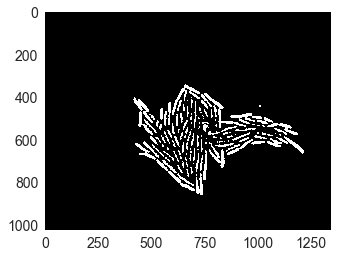

In [45]:
# Renormalize the image
im_float = (im - np.min(im))/(np.max(im) - np.min(im))

# Apply the threshold and show the segmented image
plt.imshow(im_float < threshold, cmap = plt.cm.Greys_r)
plt.grid('off')

Not too bad, but we can see that a lot of the interior cells' area was assigned as background. Neverthless, let's proceed with this procedure for all the frames and plot the total bacterial area as a function of time. The growth rate that we infer is likely to be underestimated, which we will remedy later by using the fluorescence images instead.

In [46]:
# Extract the names of all phase images
im_names = glob.glob('../data/ecoli_growth/ecoli_phase_*.tif')

# Take a look at some
im_names[0:5]

['../data/ecoli_growth/ecoli_phase_00.tif',
 '../data/ecoli_growth/ecoli_phase_01.tif',
 '../data/ecoli_growth/ecoli_phase_02.tif',
 '../data/ecoli_growth/ecoli_phase_03.tif',
 '../data/ecoli_growth/ecoli_phase_04.tif']

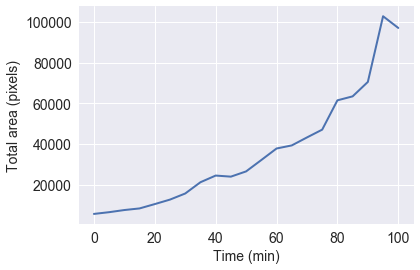

In [47]:
# Number of frames
n_frames = len(im_names)

# An array to store the bacterial areas
area_tot = np.zeros(n_frames)

# Extract the bacterial areas
for n in range(n_frames):
    
    # Read the frame
    im = skimage.io.imread(im_names[n])
    
    # Renormalize the image
    im_float = (im - np.min(im))/(np.max(im) - np.min(im))

    # Apply the threshold
    im_thresh = im_float < threshold
    
    # Add the area
    area_tot[n] = np.sum(im_thresh)
    
# Time resolution in minutes
dt = 5

# Measurement times
times = dt * np.arange(n_frames)

# Plot the time dependence of the bacterial area
plt.plot(times, area_tot)
plt.xlabel('Time (min)')
plt.ylabel('Total area (pixels)')
plt.show()

Since we are interested in the growth rate $\lambda$, let's rescale the areas so that in the first frame the area is normalized to `1`.

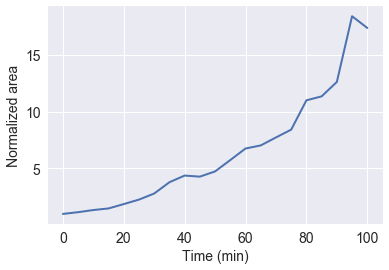

In [48]:
# Area normalization
area_tot_norm = area_tot / area_tot[0]

# Plot the normalized area
plt.plot(times, area_tot_norm)
plt.xlabel('Time (min)')
plt.ylabel('Normalized area')
plt.show()

We need to find the value of the growth rate $\lambda$ which can best explain the curve above. To that end, let's introduce a fitting error function defined as

\begin{align}
\mathrm{Err}(\lambda) = \sum_{i=1}^{N} \left(f_i- \hat{f}_i(\lambda) \right)^2,
\end{align}

where the iteration takes place over each frame. Here $f_i$ represents the normalized area at the $i^{\text{th}}$ frame, and $\hat{f}_i(\lambda) = \exp(\lambda \, t_i)$ is the theoretical prediction of the fractional growth for a given value of the growth rate. Let's write a function that evaluates the error for a given choise of $\lambda$.

In [49]:
def err (norm_area, times, rate):
    """
    Returns the fitting error of fractional bacterial area increase.
    """
    
    frac_theory = np.exp(rate*times)
    
    return np.sum((frac_theory - norm_area)**2)

Intuitively, we should choose the value of $\lambda$ that minimizes the fitting error. Let's plot the error for different values of $\lambda$ and identify the optimal value.

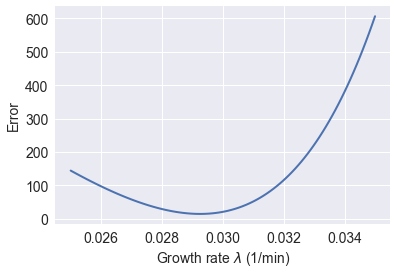

In [50]:
n_points = 100
lambda_ls = np.linspace(0.025, 0.035, n_points)
err_ls = np.zeros(n_points)
for i in range(n_points):
    err_ls[i] = err(area_tot_norm, times, lambda_ls[i])
plt.plot(lambda_ls, err_ls)
plt.ylabel('Error')
plt.xlabel(r'Growth rate $\lambda$ (1/min)')
plt.show()

In [51]:
# Index of the optimal lambda
ind_optimal = np.where(err_ls == np.min(err_ls))

# Optimal lambda
lambda_fit = lambda_ls[ind_optimal]

# Show the optimal fit
print(lambda_fit)

[ 0.02924242]


The optimal fit is $\lambda \approx 0.03$ min$^{-1}$. It corresponds to a doubling time of $\tau \approx 23$ minutes. In the final step, let's add the best growth curve on top of the experimental one to visually see the goodness of fit.

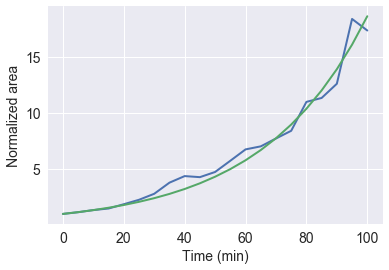

In [52]:
# Plot the normalized area
plt.plot(times, area_tot_norm)
plt.plot(times, np.exp(lambda_fit*times))
plt.xlabel('Time (min)')
plt.ylabel('Normalized area')
plt.show()

## Analysis of fluorescence microscopy images

As noted earlier, when thresholding the phase contrast images, a significant amount of bacterial area was neglected, which likely led to an underestimation of the doubling time. For a more accurate analysis we will now use fluorescence microscopy images, where the contrast between cells and the background is more pronounced.

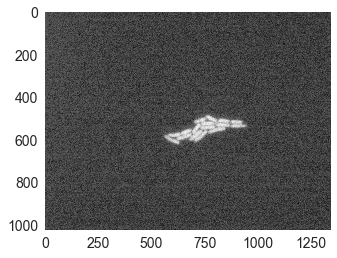

In [53]:
# Load an example fluorescence image
im = skimage.io.imread('../data/ecoli_growth/ecoli_TRITC_05.tif')

# Renormalize the image
im_float = (im - np.min(im))/(np.max(im) - np.min(im))

# Show the image
plt.imshow(im_float, cmap = plt.cm.Greys_r)
plt.grid('off')

The constrast is much better now! Unlike the phase contrast images, here the bacterial pixels are lighter than the background. Let's take a look at the pixel intensity histogram.

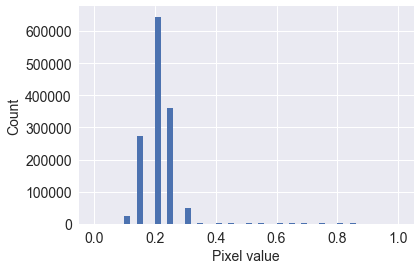

In [54]:
_ = plt.hist(im_float.flatten(), bins=50)
plt.xlabel('Pixel value')
plt.ylabel('Count')
plt.show()

A good threshold value for separating bacteria will be `0.4`.

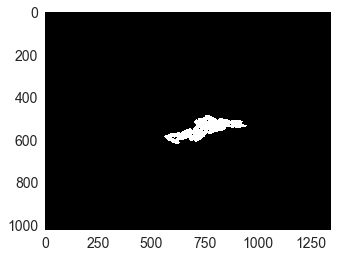

In [55]:
# Threshold
threshold = 0.40

# Apply the threshold and show the segmented image
plt.imshow(im_float > threshold, cmap = plt.cm.Greys_r)
plt.grid('off')

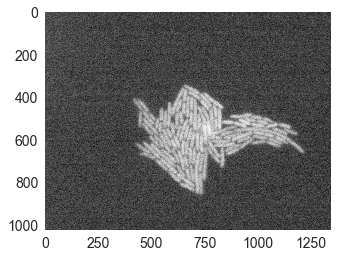

In [56]:
# Load another a different image
im = skimage.io.imread('../data/ecoli_growth/ecoli_TRITC_18.tif')

# Renormalize the image
im_float = (im - np.min(im))/(np.max(im) - np.min(im))

# Show the image
plt.imshow(im_float, cmap = plt.cm.Greys_r)
plt.grid('off')

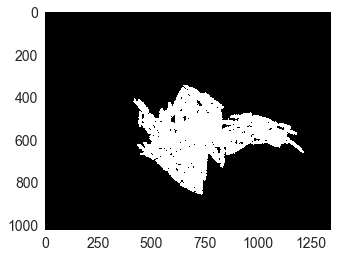

In [57]:
# Apply the threshold and show the segmented image
plt.imshow(im_float > threshold, cmap = plt.cm.Greys_r)
plt.grid('off')

Segmentation was much better with fluorescence images, compared with the phase contrast ones! Let's implement the same steps for all the frames and obtain the growth curve.

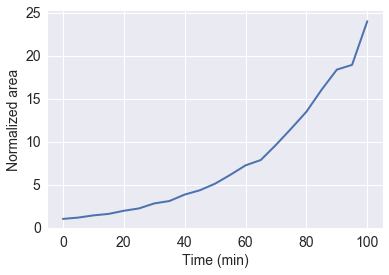

In [59]:
# Extract the names of all fluorescence images
im_names = glob.glob('../data/ecoli_growth/ecoli_TRITC_*.tif')

# Number of frames
n_frames = len(im_names)

# Variable to store the bacterial areas
area_tot = np.zeros(n_frames)

# Extract the bacterial areas
for n in range(n_frames):
    
    # Read the frame
    im = skimage.io.imread(im_names[n])
    
    # Renormalize the image
    im_float = (im - np.min(im))/(np.max(im) - np.min(im))

    # Apply the threshold
    im_thresh = im_float > threshold
    
    # Add the area
    area_tot[n] = np.sum(im_thresh)
    
# Time resolution in minutes
dt = 5

# Measurement times
times = dt * np.arange(n_frames)

# Normalize the area
area_tot_norm = area_tot / area_tot[0]

# Plot the normalized area
plt.plot(times, area_tot_norm)
plt.xlabel('Time (min)')
plt.ylabel('Normalized area')
plt.show()

The growth curve looks much smoother now! Let's plot the error function and find the more accurate estimate.

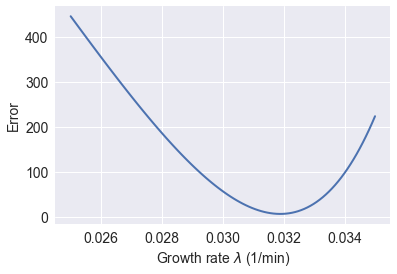

In [60]:
n_points = 100
lambda_ls = np.linspace(0.025, 0.035, n_points)
err_ls = np.zeros(n_points)
for i in range(n_points):
    err_ls[i] = err(area_tot_norm, times, lambda_ls[i])
plt.plot(lambda_ls, err_ls)
plt.ylabel('Error')
plt.xlabel(r'Growth rate $\lambda$ (1/min)')
plt.show()

In [61]:
# Index of the optimal lambda
ind_optimal = np.where(err_ls == np.min(err_ls))

# Optimal lambda
lambda_fit = lambda_ls[ind_optimal]

# Show the optimal lambda
print(lambda_fit)

[ 0.03186869]


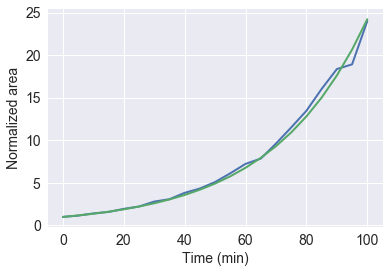

In [62]:
# Plot the normalized area with the best theoretical fit
plt.plot(times, area_tot_norm)
plt.plot(times, np.exp(lambda_fit*times))
plt.xlabel('Time (min)')
plt.ylabel('Normalized area')
plt.show()

With the fluroescence data we found the best fit of the growth rate to be $\lambda \approx 0.032$ sec$^{-1}$, corresponding to a doubling time of $\tau \approx 21.5$ sec. This result is slightly faster than what we found with phase contrast images. A likely explanation to why the estimate with phase contrast images doesn't fall behind much is that the area of the bacterial colony is being underestimated consistently at all frames, which doesn't significantly affect the growth rate estimate.